In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import scipy.signal as ss
from matplotlib import rc
from astropy.modeling.models import Gaussian2D
from photutils.isophote import EllipseGeometry
from photutils import EllipticalAperture
from photutils.isophote import Ellipse
from photutils.isophote import build_ellipse_model
plt.rcParams.update({'font.size': 10})
plt.rc('font', family='serif')

rot_freq = 12

In [2]:
B = np.load('pulseB_349.0.npy')

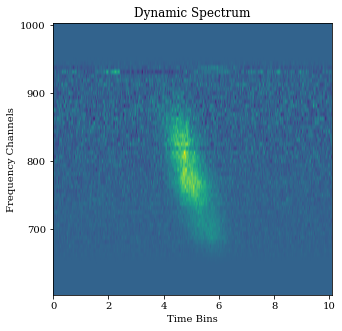

In [7]:
subfac = 16
sub = rb_sub = np.nanmean(B.reshape(-1, subfac, B.shape[1]), axis=1)
sav = ss.savgol_filter(sub, 49, 6)
sav_c = sav[:, 1250:1750]
fig = plt.figure(figsize = (5, 5))
plt.imshow(sub[:, 1250:1750], aspect = 'auto')
#plt.plot(sub[:, 1250:1750].sum(0))
plt.ylabel('Frequency Channels')
plt.xlabel('Time Bins')
plt.title('Dynamic Spectrum')
plt.yticks(np.arange(0, sav_c.shape[0], 16), [1000, 900, 800, 700, 600])
plt.xticks(np.arange(0, sav_c.shape[1], 99), [0, 2, 4, 6, 8, 10])
plt.show()
fig.savefig('B_dynspec.png')

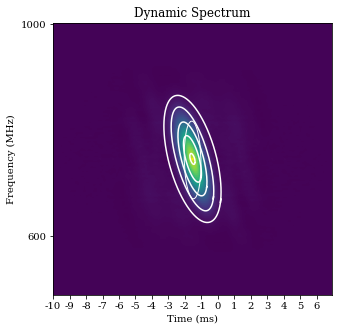

In [89]:
xhi = 1750
xlo = 1250

sav_c = sav[:, xlo:xhi]

#Calculate 2D ACF
acf = ss.correlate(sav_c, sav_c)

#Mask acf to eliminate peakiness
#acf[len(acf.sum(1))//2 -1 : len(acf.sum(1))//2 +1, :] \
#    = np.ones(len(acf.sum(0)))*np.mean(acf[len(acf.sum(1))//2 +1:len(acf.sum(1))//2 +5, :])

#Cap acf values
#cap = np.mean(acf[len(acf.sum(1))//2 +1:len(acf.sum(1))//2 +2, len(acf.sum(0))//2 +10:len(acf.sum(0))//2 +20])
#acf[acf > cap] = cap

#Initial Guess Ellipse Parameters
sma = 30
eps = 0.4
pa = 0.1
#pa = 60 * np.pi/180

#Provide the initial Ellipse to be fitted
#Calculate Ellipse Geometry
geometry = EllipseGeometry(x0 = acf.shape[1]/2, \
            y0 = acf.shape[0]/2, sma = sma, eps = eps, pa = pa)
#Show Initial Guess Ellipsee
aper = EllipticalAperture((geometry.x0, geometry.y0), \
            geometry.sma, geometry.sma*(1-geometry.eps),geometry.pa)

#Plot Initial Guess Ellipse on ACF
fig = plt.figure(figsize = (5, 5))
plt.imshow(acf, aspect = 'auto')
plt.ylabel('Frequency (MHz)')
plt.xlabel('Time (ms)')
plt.title('Dynamic Spectrum')
plt.yticks(range(0, acf.shape[0], 99), [1000, 600, 200, 0, -200, -600, -1000])
plt.xticks(np.arange(0, acf.shape[1], 59), np.arange(-10,10))
aper.plot(color='white')
#fig.savefig('A.png')

#Fit Ellipse to 2D ACF
try:
    ellipse = Ellipse(acf, geometry)
    isolist = ellipse.fit_image()
    model_image = build_ellipse_model(acf.shape, isolist)
    residual = acf - model_image
    
    smas = np.linspace(10, 100, 5)
    for sma in smas:
        iso = isolist.get_closest(sma)
        x, y, = iso.sampled_coordinates()
        plt.plot(x, y, color='white')
except OverflowError:
    print('Note: Overflow Error')
    pass
except ValueError:
    print('Note: Value Error')
    pass
except IndexError:
    print('Ellipse Fit Failed!')
    pass


0.23290239062653045


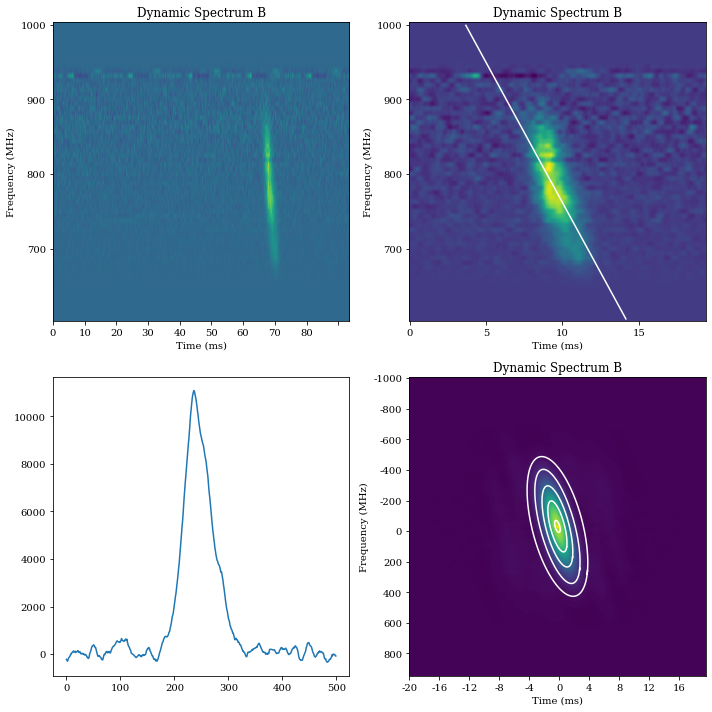

In [181]:
fig = plt.figure(figsize = (10, 10))
ax1 = fig.add_subplot(221)


sav_c = sav[:, 1250:1750]

plt.imshow(sub, interpolation = None, aspect = 'auto')
plt.yticks(np.arange(0, sub.shape[0], 16), [1000, 900, 800, 700, 600])
plt.xticks(np.arange(0, sub.shape[1], 219), [0, 10, 20, 30, 40, 50, 60, 70, 80])
plt.ylabel('Frequency (MHz)')
plt.xlabel('Time (ms)')
plt.title('Dynamic Spectrum B')

ax2 = fig.add_subplot(222)
plt.imshow(sav_c,  interpolation = None, aspect = 'auto')
plt.yticks(np.arange(0, sav_c.shape[0], 16), [1000, 900, 800, 700, 600])
plt.xticks(np.arange(0, sav_c.shape[1], 129), [0, 5, 10, 15, 20])
plt.ylabel('Frequency (MHz)')
plt.xlabel('Time (ms)')
plt.title('Dynamic Spectrum B')
x1 = np.linspace(95, 365, 209)
def y(x):
    return (np.tan(np.max(isolist.pa))) * x - 22
y1 = y(x1)
#print(y1)
plt.plot(x1, y1, c = 'w')
print(np.tan(np.max(isolist.pa)))

ax3 = fig.add_subplot(223)
plt.plot(sav_c.sum(0))


ax4 = fig.add_subplot(224)
plt.imshow(acf, aspect = 'auto')
plt.yticks(np.arange(0, acf.shape[0], 13), np.arange(-1000, 1000, 200))
plt.xticks(np.arange(0, acf.shape[1], 101), np.arange(-20, 20, 4))
smas = np.linspace(10, 100, 5)
for sma in smas:
    iso = isolist.get_closest(sma)
    x, y, = iso.sampled_coordinates()
    plt.plot(x, y, color='white')
#Plot Drift Rate Line
x1 = np.linspace(0, acf.shape[1]//2-1, acf.shape[1]//2)
def y(x):
    return (np.tan(np.max(isolist.pa))) * x +37
#y1 = y(x1)
##print(y1)
#plt.plot(x1, y1)
#print(np.tan(np.max(isolist.pa)))
plt.ylabel('Frequency (MHz)')
plt.xlabel('Time (ms)')
plt.title('Dynamic Spectrum B')

plt.tight_layout()
plt.show()
fig.savefig('B_fourplot.png')